In [1]:
#necessary if running in Google Colab
%pip install qiskit
%pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=09f753a3b2bbf582d183734f3dfdaa9e7464f8f7c0539f888c264ee8f5784539
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [89]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Qubit
from qiskit.quantum_info import Statevector, Operator, random_unitary

from qiskit.circuit.library.standard_gates import HGate, XGate, ZGate
from qiskit.circuit.library import RYGate, RZGate

import matplotlib.pyplot as plt

import numpy as np

#Z-Y Decomposition

Recall the following single qubit gates:

$R_y(\theta) =
\begin{bmatrix}
  \cos(\frac\theta2) & -\sin(\frac\theta2) \\
  \sin(\frac\theta2) & \cos(\frac\theta2)
\end{bmatrix}$

$R_z(\theta) =
\begin{bmatrix}
  e^{-i\theta/2} & 0 \\
  0 & e^{i\theta/2}
\end{bmatrix}
$

The implementation of multi-controlled gates depends on the fact for any unitary $U$, there exist real numbers $\alpha, \beta, \gamma, \delta$ such that
$U = e^{i\alpha}R_z(\beta)R_y(\gamma)R_z(\delta)$.

In [3]:
def ZYDecomposition(U):
  w,x,y,z = U[0][0], U[0][1], U[1][0], U[1][1]

  gamma = 2*np.arccos(np.absolute(w))
  a = np.angle(w)
  b = np.angle(y/np.sin(gamma/2))
  c = np.angle(z)
  alpha = (a + c)/2
  beta = b-a
  delta = c-b

  return alpha, beta, gamma, delta

U = random_unitary(2).to_matrix()
alpha, beta, gamma, delta = ZYDecomposition(U)
U2 = np.exp(1j*alpha)*RZGate(beta).to_matrix() @ RYGate(gamma).to_matrix() @ RZGate(delta).to_matrix()

In [4]:
#let's decompose a random unitary matrix
U = random_unitary(2).to_matrix()
U

array([[ 0.39705184+0.47746393j, -0.23300755-0.74838861j],
       [-0.77933845-0.08372338j, -0.54529514-0.29711139j]])

In [5]:
alpha, beta, gamma, delta = ZYDecomposition(U)
Z1 = RZGate(beta).to_matrix()
Y = RYGate(gamma).to_matrix()
Z2 = RZGate(delta).to_matrix()
U2 = np.exp(1j*alpha)*Z1 @ Y @ Z2
U2

array([[ 0.39705184+0.47746393j, -0.23300755-0.74838861j],
       [-0.77933845-0.08372338j, -0.54529514-0.29711139j]])

#Singly-Controlled Gate

Given a single qubit gate $U$, we can implement the controlled version $CU$ by first obtaining $\alpha, \beta, \gamma, \delta$ as above and then noticing that for

$A := R_z(\beta)R_y(\frac\gamma 2)$

$B := R_y(\frac{-\gamma} 2)R_z(\frac{-\delta - \beta} 2)$

$C := R_z(\frac{\delta - \beta}2)$

we have $ABC = I$ and $e^{i\alpha}AXBXC = U$.

In [6]:
def SingleControlledGate(U):
  alpha, beta, gamma, delta = ZYDecomposition(U)
  A = RZGate(beta).to_matrix() @ RYGate(gamma/2).to_matrix()
  B = RYGate(-gamma/2).to_matrix() @ RZGate(-(delta + beta)/2).to_matrix()
  C = RZGate((delta-beta)/2).to_matrix()

  register = QuantumRegister(2,name="x")
  CU = QuantumCircuit(register, name="Controlled U")
  #apply C
  CU.rz((delta-beta)/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply B
  CU.rz((-delta-beta)/2, register[1])
  CU.ry(-gamma/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply A
  CU.ry(gamma/2, register[1])
  CU.rz(beta, register[1])
  CU.p(alpha, register[0])

  return CU

In [7]:
#let's confirm this implementation works
U = random_unitary(2).to_matrix()
U

array([[-0.14214343+0.79584385j, -0.03541243+0.58751492j],
       [ 0.25115036+0.53230754j, -0.42764017-0.68607293j]])

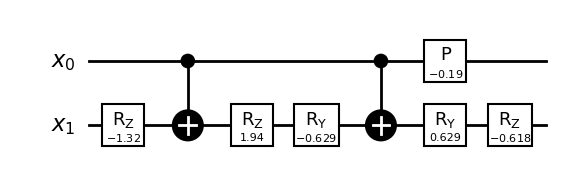

In [8]:
CU = SingleControlledGate(U)
CU.draw(output="mpl", style="bw")

In [9]:
np.round(Operator(CU).data, 3)

array([[ 1.   +0.j   ,  0.   +0.j   , -0.   -0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   , -0.142+0.796j,  0.   +0.j   , -0.035+0.588j],
       [ 0.   -0.j   ,  0.   +0.j   ,  1.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.251+0.532j,  0.   +0.j   , -0.428-0.686j]])

#Toffoli Gate

The above construction of the singly-controlled gate $CU$ from $U$ can be iterated to obtain the doubly-controlled gate $CCU$. This implemmentation requires a number of single qubit gates which is exponential in the number of control qubits.

More efficient implementations of multi-controlled gates can be built from Toffoli gates and singly-controlled gates. For completeness, here is an example of an implementation of the Toffoli gate.

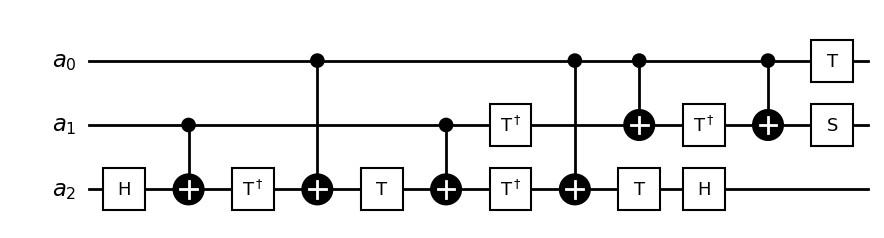

In [10]:
toffoli_register = QuantumRegister(size=3, name="a")
toffoli_circuit = QuantumCircuit(toffoli_register)
toffoli_circuit.h(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[1], toffoli_register[2])
toffoli_circuit.tdg(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[0], toffoli_register[2])
toffoli_circuit.t(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[1],toffoli_register[2])
toffoli_circuit.tdg(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[0],toffoli_register[2])
toffoli_circuit.t(toffoli_register[2])
toffoli_circuit.tdg(toffoli_register[1])
toffoli_circuit.h(toffoli_register[2])
toffoli_circuit.cx(toffoli_register[0],toffoli_register[1])
toffoli_circuit.tdg(toffoli_register[1])
toffoli_circuit.cx(toffoli_register[0],toffoli_register[1])
toffoli_circuit.t(toffoli_register[0])
toffoli_circuit.s(toffoli_register[1])

toffoli_circuit.draw(output="mpl", style="bw")

In [11]:
np.round(np.real(Operator(toffoli_circuit).data))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

#Multi-Controlled Gate

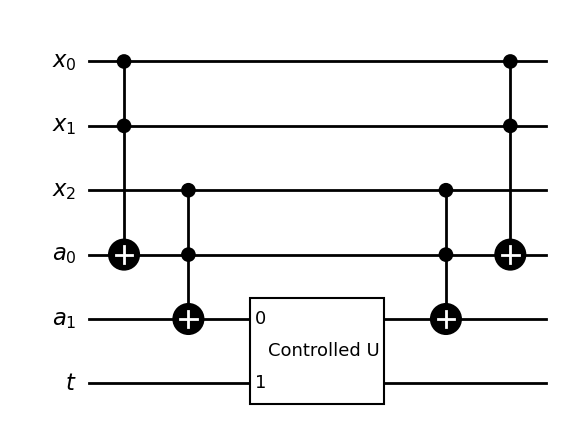

In [12]:
def MultiControlledGate(n ,U):
  control_register = QuantumRegister(size=n, name="x")
  ancilla_register = AncillaRegister(size=n-1, name="a")
  target_register = QuantumRegister(size=1, name="t")

  #prepares a subroutine which stores the conjunction of all the x[i]s in a[n-2]
  setup = QuantumCircuit(control_register, ancilla_register, name="setup")
  setup.ccx(control_register[0], control_register[1], ancilla_register[0])
  for i in range(2, n):
    setup.ccx(control_register[i], ancilla_register[i-2], ancilla_register[i-1])

  final = QuantumCircuit(control_register, ancilla_register, target_register, name="multicontrolledU")
  final.compose(setup, inplace=True)
  final.append(SingleControlledGate(U).to_gate(), [ancilla_register[n-2], target_register[0]])
  final.compose(setup.inverse(), inplace=True)

  return final

MultiControlledGate(3,U).draw(output="mpl", style="bw")

In [171]:
#if the first five qubits are |11100>, then this circuit applies
#U to the last qubit. In other words, we should see the matrix
#for U as a submatrix with rows and columns indexed by |11100> (7)
#and |11101> (39)
U, Operator(MultiControlledGate(3,U)).data[np.ix_([7,39],[7,39])]

(array([[-0.14214343+0.79584385j, -0.03541243+0.58751492j],
        [ 0.25115036+0.53230754j, -0.42764017-0.68607293j]]),
 array([[-0.14214343+0.79584385j, -0.03541243+0.58751492j],
        [ 0.25115036+0.53230754j, -0.42764017-0.68607293j]]))

This method is useful because the number of gates used is linear in the number of control qubits. It is also conceptually very clear: by storing the conjunction of all the control bits in the final ancilla bit, we only need one singly-controlled bit.
The downside is that the number of ancilla qubits used is also linear in the number of control qubits.

There is a clever way of computing the conjunction of all the control bits which uses just two ancilla qubits. We give another implementation using this trick, and now the number of gates is still linear in the number of control qubits, but the number of ancillas is constant.

The first stop on the path to the constant-space And circuit is the Flip circuit.

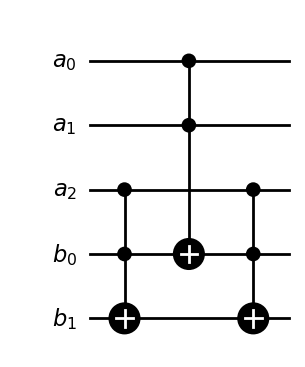

In [56]:
#Returns: a QuantumCircuit with an "a" register of size n
#and a "b" register of size n-1.
#The circuit fixes the "a" register, and and adds the conjunction
#of a_0,...,a_i to b_(i-1)
def Flip(n):
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=n-1, name = "b")
  F = QuantumCircuit(a_register, b_register, name="Flip" + str(n))
  for i in range(n-2):
    F.ccx(a_register[n-1-i], b_register[n-3-i], b_register[n-2-i])
  F.ccx(a_register[0], a_register[1], b_register[0])
  for i in range(n-2):
    F.ccx(a_register[i+2], b_register[i], b_register[i+1])
  return F

Flip(3).draw(output="mpl", style="bw")

In [90]:
#for example, the flip circuit applied to the input
# |11101>|0000> should be |11101>|1100>
input_bin = [1,1,1,0,1]
n = len(input_bin)

def flip(s):
  ret = [s[0] & s[1]]
  for i in range(2,len(s)):
    ret = ret + [ret[i-2] & s[i]]
  return ret

def binary_to_int(b):
  return sum([int(a[1])*2**int(a[0]) for a in enumerate(b)])

expected_bin = input_bin + flip(input_bin)

#extract the value of input_bin, interpreted as little endian binary
input = binary_to_int(input_bin)
dim = 2**(2*n - 1)

initial_state = Statevector.from_int(input, dim)

#apply the flip circuit to the initial state
final_state = initial_state.evolve(Flip(n))
expected_state = Statevector.from_int(binary_to_int(expected_bin),dim)

#we get the expected state
np.linalg.norm(final_state-expected_state), expected_bin

(np.float64(0.0), [1, 1, 1, 0, 1, 1, 1, 0, 0])

With the Flip circuit, we can construct a circuit AndTemp which uses $n-2$ spare qubits to add the conjunction of $n$ qubits to another qubit.

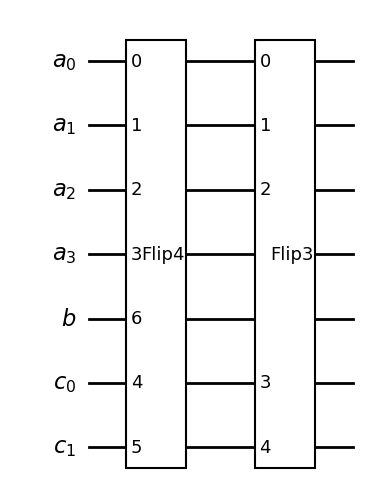

In [74]:
#returns: A QuantumCircuit with an "a" register of size n,
#a "b" register of size 1, and a "c" register of size n-2
#The circuit fixes the "a" and "c" registers, and adds the
#conjuction of all the "a" qubits to the "b" qubit.
def AndTemp(n):
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=1, name = "b")
  c_register = QuantumRegister(size=n-2, name = "c")
  andtemp_circuit = QuantumCircuit(a_register, b_register, c_register, name="AndTemp" + str(n))

  if n == 2:
    andtemp_circuit.ccx(a_register[0], a_register[1], b_register[0])
    return andtemp_circuit

  andtemp_circuit.compose(Flip(n).to_gate(), qubits=list(range(n)) + list(range(n+1,2*n-1)) + [n], inplace=True)
  andtemp_circuit.compose(Flip(n-1).to_gate(), qubits=list(range(n-1)) + list(range(n+1,2*n-1)), inplace=True)
  return andtemp_circuit

AndTemp(4).draw(output="mpl", style = "bw")

In [91]:
#example showing that AndTemp(4) takes the state
#|1111||0>|10> to |1111>|1>|10>
input_bin = [1,1,1,1,0,1,0]
expected_bin = [1,1,1,1,1,1,0]

initial_state = Statevector.from_int(binary_to_int(input_bin), 2**7)
final_state = initial_state.evolve(AndTemp(4))
expected_state = Statevector.from_int(binary_to_int(expected_bin),2**7)

np.linalg.norm(final_state-expected_state)

np.float64(0.0)

Finally, to implement the And gate, we use AndTemp to store the conjunction of the first (second) half of the qubits, while using the second (first) half of the qubits as the temporary qubits.

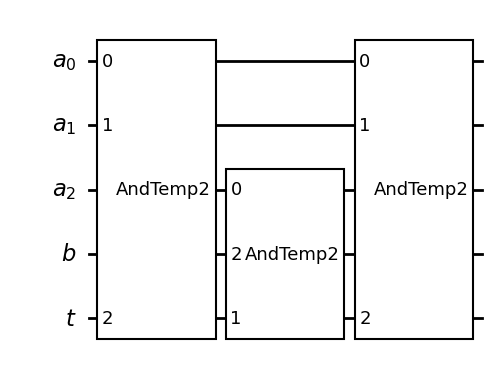

In [180]:
#returns: a Quantum circuit which stores the conjunction of n
#qubits in a qubit b, and uses an ancilla t which must start
#in the state |0>
def And(n):
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=1, name = "b")
  t_register = AncillaRegister(size=1, name = "t")
  and_circuit = QuantumCircuit(a_register, b_register, t_register, name="And" + str(n))
  m = int((n+1)/2)
  upper_half_qubits = list(range(m)) + [n+1] + list(range(m,2*m-2))
  lower_half_qubits = list(range(m, n)) + [n+1,n] + list(range(n-m-1))

  and_circuit.compose(AndTemp(m).to_gate(), qubits=upper_half_qubits, inplace=True)
  and_circuit.compose(AndTemp(n-m+1).to_gate(), qubits=lower_half_qubits, inplace=True)
  and_circuit.compose(AndTemp(m).to_gate(), qubits=upper_half_qubits, inplace=True)

  return and_circuit

And(3).draw(output="mpl", style = "bw")

In [176]:
#example showing that And(5) takes the state |11111>|0>|0>
#to the state |11111>|1>|0>
input_bin = [1,1,1,1,1,0,0]
expected_bin = [1,1,1,1,1,1,0]

initial_state = Statevector.from_int(binary_to_int(input_bin), 2**7)
final_state = initial_state.evolve(And(5))
expected_state = Statevector.from_int(binary_to_int(expected_bin),2**7)

np.linalg.norm(final_state-expected_state)

np.float64(0.0)

Now that we have an And circuit which uses a constant number of ancillas, we can create another multicontrolled gate which uses a constant number of ancillas.

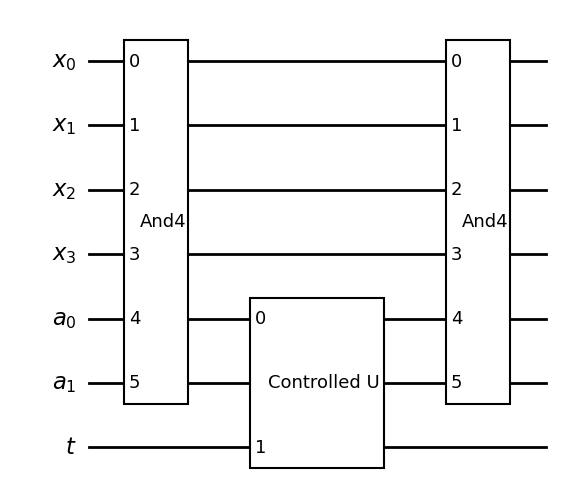

In [177]:
def MultiControlledGate2(n ,U):
  control_register = QuantumRegister(size=n, name="x")
  ancilla_register = AncillaRegister(size=2, name="a")
  target_register = QuantumRegister(size=1, name="t")

  multicontrolled_circuit = QuantumCircuit(control_register, ancilla_register, target_register)

  #store the conjunction of all the x[i]s in a
  multicontrolled_circuit.compose(And(n).to_gate(), inplace=True)
  multicontrolled_circuit.compose(SingleControlledGate(U).to_gate(), qubits= [ancilla_register[0], target_register[0]], inplace=True)
  multicontrolled_circuit.compose(And(n).to_gate(), inplace=True)

  return multicontrolled_circuit

MultiControlledGate2(4,U).draw(output="mpl", style="bw")

In [179]:
#if the first six qubits are |111100>, then this circuit applies
#U to the last qubit. In other words, we should see the matrix
#for U as a submatrix with rows and columns indexed by |1111000> (15)
#and |1111001> (79)
U, Operator(MultiControlledGate2(3,U)).data[np.ix_([7,39],[7,39])]

(array([[-0.14214343+0.79584385j, -0.03541243+0.58751492j],
        [ 0.25115036+0.53230754j, -0.42764017-0.68607293j]]),
 array([[-0.14214343+0.79584385j, -0.03541243+0.58751492j],
        [ 0.25115036+0.53230754j, -0.42764017-0.68607293j]]))